In [2]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

# Code Consolidation

This notebook consolidates the codes applied to the textual descriptions of requirements-affected activities and their attributes from the data generated during this study.

In [3]:
df = pd.read_excel('./../2-data-coding/r3a-data-extraction.xlsx', sheet_name='Data')

In [4]:
data_sources = {
    'E': 'experimental literature',
    'I': 'interview study',
    'S': 'software process literature'
}

In [5]:
variables = ['Activity', 'Activity Attributes', 'Artifact', 'Artifact Attributes']

In [6]:
def get_unique_codes(df: pd.DataFrame, column: str) -> [str]:
    """Returns a list of unique codes contained in a given column.

    parameters:
        df -- pandas.DataFrame containing the data
        column -- name of the column containing cells with codes or groups of codes separated by semicolons (e.g., "code1;code2)

    returns:
        list of unique codes
    """

    # obtain all codes of the column (which still contains code groups like "code1;code2")
    all_codes = list(df[column].value_counts().index)

    # split up code groups (the sum([...], []) flattens the list of lists)
    singular_codes = sum([code.split(';') for code in all_codes], [])

    # remove duplicates
    return list(set(singular_codes))

## Data Cleaning

Firstly, we perform the data cleaning process as outlined in the [data evaluation](data-evaluation.ipynb) notebook. This includes the removal of all experimental studies which did not meet all inclusion or any of the exclusion criteria once evaluated on the full text, and the exclusion of data points (activity-attribute description pairs) where the attribute does not imply a valuation.

In [7]:
df = df[df['F']==False] # remove all these wrongfully included primary studies (i.e., false positives) from the data set
df = df[df['Val']==False] # remove all these wrongfully included data points (i.e., false positives) from the data set

## Code Statistics

In order to generate statistics about the distribution of codes, we first obtain the list of unique codes occuring in the data.

In [8]:
codes = {variable: get_unique_codes(df, variable) for variable in variables}

### Codes per Data Source

Next, we visualize the distribution of the unique codes per data source.

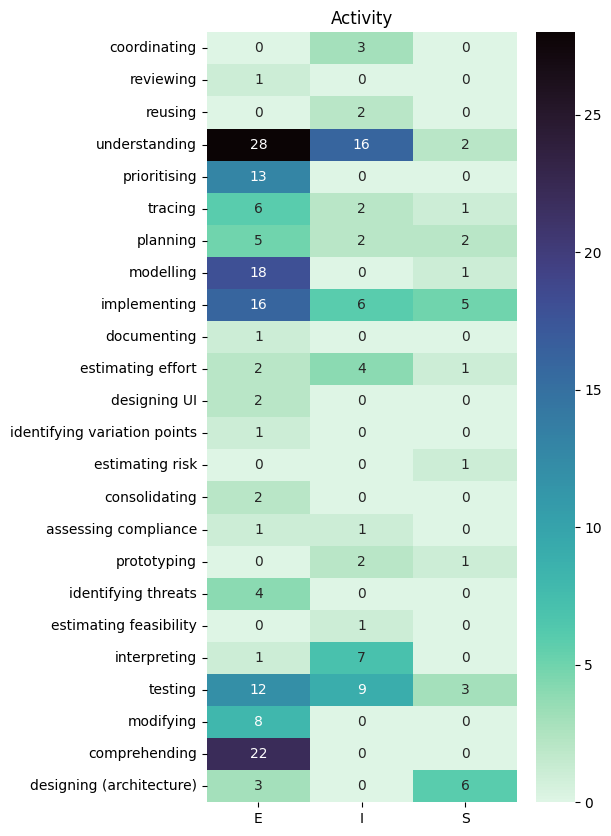

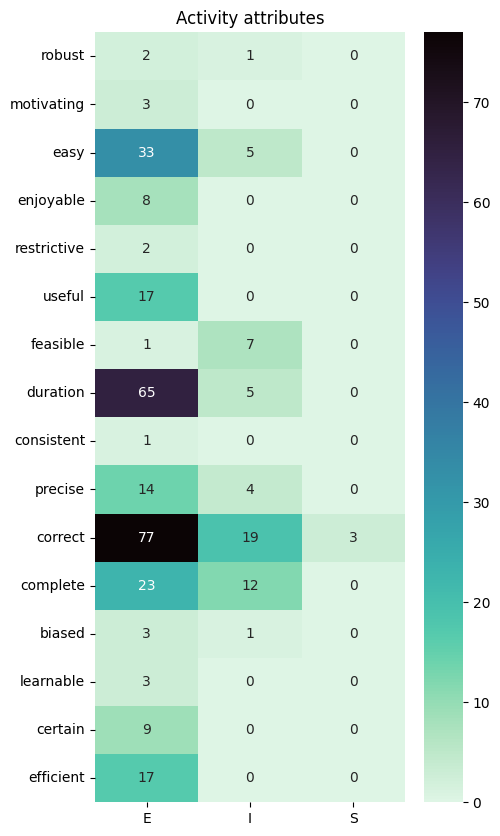

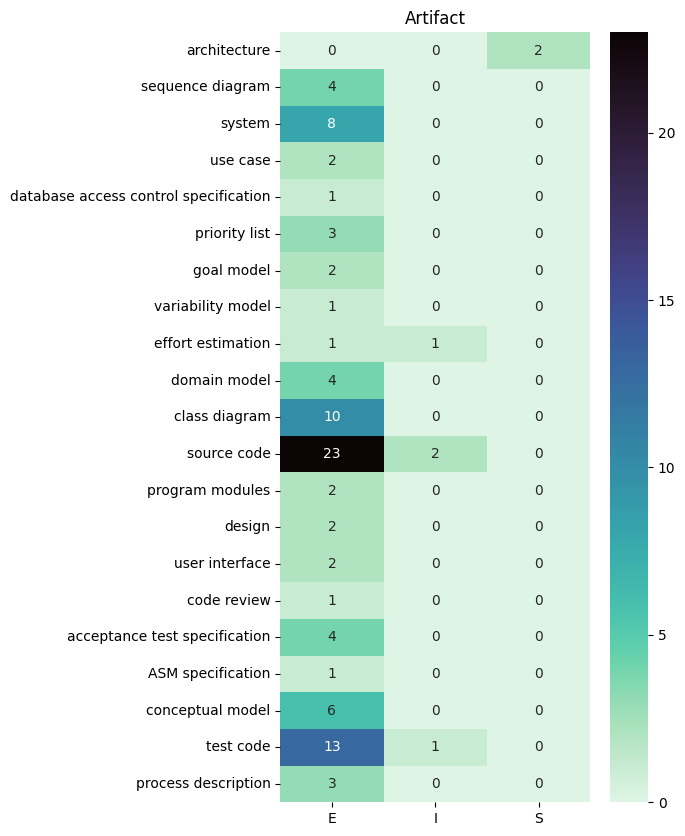

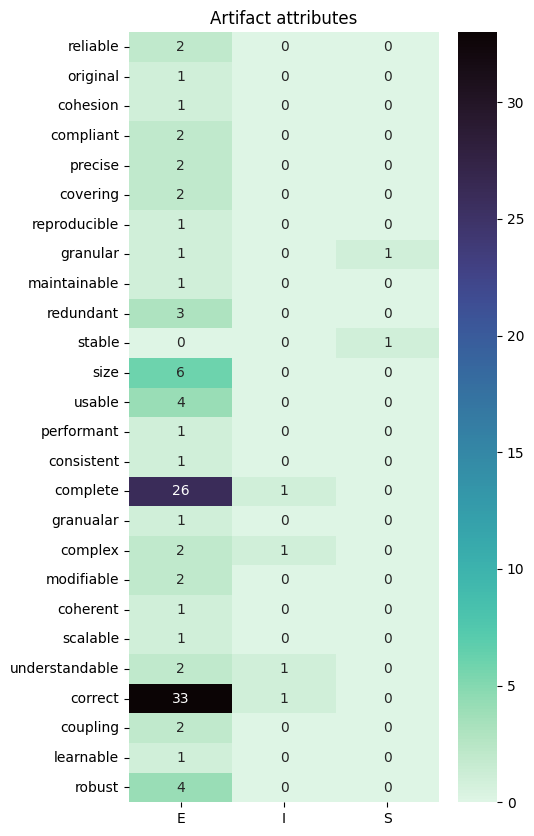

In [9]:
for variable in variables:
    mention_count = {code: [0, 0, 0] for code in codes[variable]}
    mentions = pd.DataFrame.from_dict(mention_count, orient='index', columns=data_sources)

    for index, row in df.iterrows():
        # check that this row actually contains an activity code (and not nan)
        if type(row[variable]) == str:
            all_mentioned = row[variable].split(';')
            for mentioned in all_mentioned:
                mentions.loc[mentioned][row['Type']] += 1

    plt.rcParams["figure.figsize"] = (5,10)
    ax = sns.heatmap(mentions, annot= True, cmap='mako_r')
    ax.set_title(variable.capitalize())
    plt.show()

### Distribution of Attributes

Additionally, we determine which attributes are applicable to which activities/artifacts according to the extracted data. This provides associations between entities (activities/artifacts) and their attributes.

In [10]:
# expand the dataframe, i.e., fill in all activity codes that were skipped
df_exp = df.copy()

current_activity = ''

for index, row in df_exp.iterrows():    
    # detect if the current activity code is NaN (i.e., its type is float)
    if type(row['Activity']) == float:
        df_exp.at[index, 'Activity'] = current_activity
    else:
        if current_activity != row['Activity']:
            current_activity = row['Activity']

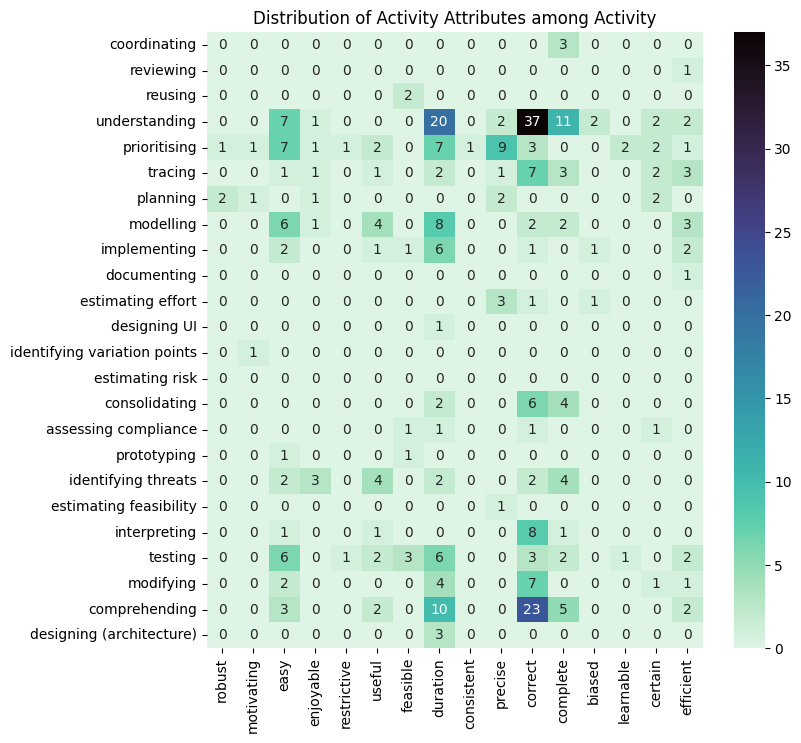

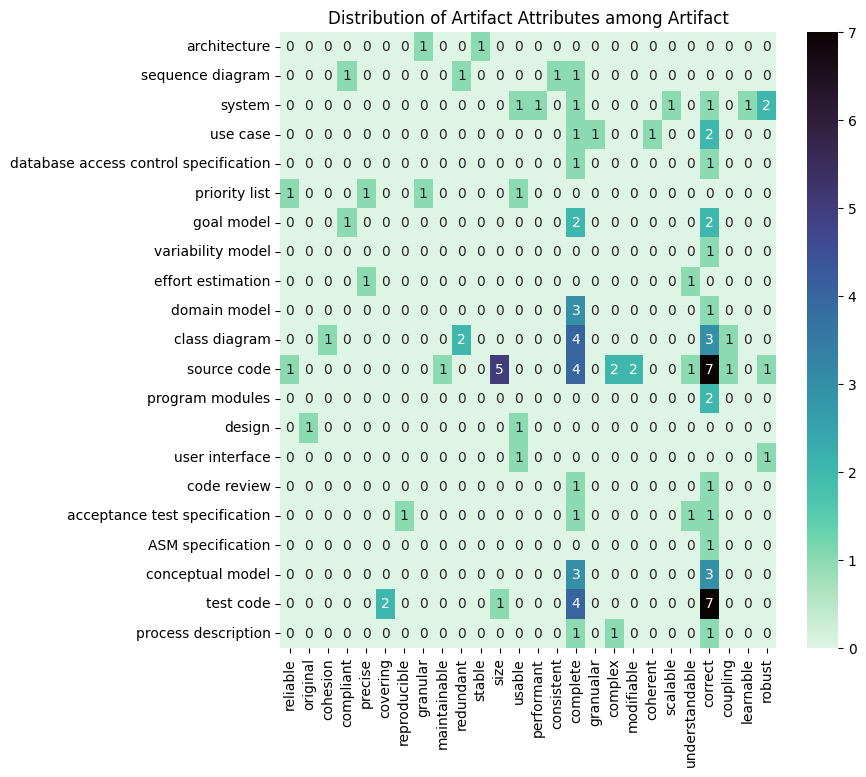

In [11]:
plt.rcParams["figure.figsize"] = (8,8)

for type_entity, type_attribute in zip(['Activity', 'Artifact'], ['Activity Attributes', 'Artifact Attributes']):
    # prepare the matrix in a data frame
    association = {entity: [0 for attribute in codes[type_attribute]] for entity in codes[type_entity]}
    matrix = pd.DataFrame.from_dict(association, orient='index', columns=codes[type_attribute])

    for index, row in df_exp.iterrows():
        if type(row[type_entity]) == str and type(row[type_attribute]) == str:
            coded_entities = row[type_entity].split(';')
            coded_attributes = row[type_attribute].split(';')

            for coded_entity in coded_entities:
                for coded_attribute in coded_attributes:
                    matrix.loc[coded_entity][coded_attribute] += 1

    ax = sns.heatmap(matrix, annot= True, cmap='mako_r')
    ax.set_title(f'Distribution of {type_attribute} among {type_entity}')
    plt.show()

## Artifact Production

In our model of requirements-affected activities, we acknowledge that some activities are evaluated via the artifacts which they produce. In order to identify, which activities produce which artifacts, we determine associations between activity and artifact codes.

In [12]:
produced_artifacts = {activity: set() for activity in codes['Activity']}

# traverse the subset of the data frame where both an activity and an artifact code is given
for index, row in df_exp[df_exp['Activity'].notnull() & df_exp['Artifact'].notnull()].iterrows():
    # add the artifact as an output to all activities mentioned by that data point
    for activity in row['Activity'].split(';'):
        produced_artifacts[activity].add(row['Artifact'])

In [13]:
print('The following artifacts are produced by the respective activities:')
for activity in produced_artifacts:
    if len(produced_artifacts[activity]) > 0:
        print(f' * {activity.capitalize()}: {", ".join(produced_artifacts[activity])}')

The following artifacts are produced by the respective activities:
 * Reviewing: code review
 * Prioritising: priority list
 * Modelling: ASM specification, sequence diagram, domain model, use case, class diagram, goal model, conceptual model, process description, variability model
 * Implementing: source code, system, database access control specification, user interface
 * Estimating effort: effort estimation
 * Designing ui: design
 * Testing: acceptance test specification, test code
 * Modifying: source code
 * Designing (architecture): architecture, source code, program modules


## Study References

Finally, we produce a list of references per activity and attribute from the experimental literature. This shall help to find appropriate experimental literature and, therefore, appropriate measurement techniques, for specific attributes of specific activities.

In [14]:
df_experiment = df_exp[df_exp['Type']=='E']

In [35]:
# prepare the matrix in a data frame
association = {activity: [set() for attribute in codes['Activity Attributes']] for activity in codes['Activity']}
study_matrix = pd.DataFrame.from_dict(association, orient='index', columns=codes['Activity Attributes'])

# traverse all rows of the (expanded) data frame
for index, row in df_experiment.iterrows():
    # if both an activity and activity attribute code is given
    if type(row['Activity']) == str and type(row['Activity Attributes']) == str:
        # determine all affected activities and attributes
        coded_activities = row['Activity'].split(';')
        coded_attributes = row['Activity Attributes'].split(';')

        # add the current study to the set of studies, that measure the current attribute of the current activity
        for coded_activity in coded_activities:
            for coded_attribute in coded_attributes:
                study_matrix.loc[coded_activity][coded_attribute].add(row['ID'])

In [37]:
study_matrix.applymap(lambda cell: ', '.join(cell)).to_excel('./activity-attribute-studies.xlsx', sheet_name='Eligible Studies')